# **Import All Dependencies Required to Run Code**

In [1]:
!pip install tensorflow_addons
!pip install sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=84ac015f8cbf31f9081314efc049ad5ed67adaf1d162d8858cffda48d9ad25f3
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import warnings
import sklearn

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, Normalizer, KBinsDiscretizer
from sklearn import metrics
import datetime
import time

from google.colab import drive
drive.mount('/content/gdrive')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/gdrive


# **Import Data and Process**

All data was retrieved from RBPDB and is in the form os a csv file. For ease, to use in this notebook, the import will occur from Google Drive. 

In [3]:
dataset_path = "/content/gdrive/My Drive/RBP_PrePData.csv"
df_preprocess = pd.read_csv(dataset_path)
df = df_preprocess[df_preprocess["Qc"]!=1]
df.head()

,Sequence,Structure,MFE,K,KA,RKA,Qc,sevenMer
0,GGAUCCAUUCAAAAAAAGAACGGAUCC,((((((.(((.......))).)))))),-10.5,4.971544,0.201145,0.395847,0,AAAAAAA
1,GGAUCCAUUCAAAAAACGAACGGAUCC,((((((.(((.......))).)))))),-10.5,4.514383,0.221514,0.435934,0,AAAAAAC
2,GGAUCCAUUCAAAAAAGGAACGGAUCC,((((((.(((.......))).)))))),-10.4,3.609146,0.277074,0.545273,0,AAAAAAG
3,GGAUCCAUUCAAAAAAUGAACGGAUCC,((((((.((((.....)))).)))))),-11.7,6.607685,0.151339,0.297831,0,AAAAAAU
4,GGAUCCAUUCAAAAACAGAACGGAUCC,((((((.(((.......))).)))))),-10.5,3.221327,0.310431,0.610919,0,AAAAACA


In [4]:
#These are the hyperparameters that I decided to employ for the project. There is a large amount of variation when it comes to this and can be adjusted around for optimal model training and testing
seq_length=7
num_layers=1
d_model=21
num_heads=3
dff=64


def cutWord(x, window=1, length = seq_length):
    seq2word = []
    for i in range(length):
        seq2word.append(x[i*window:i*window+window])
    return " ".join(seq2word)

def RKA_bin(x):
    if x >= 0.8:
        return(1)
    else:
        return(0)

def MFE_bin(x):
    if x >= -14.:
        return(1)
    else:
        return(0)

# **Sort and Seperate Data for Model**

In [9]:
scaler = MinMaxScaler()
scaler.fit(df[["RKA"]])
df["RKA_norm"] = scaler.transform(df[["RKA"]])   #Actually may not need these two lines of code
df[["RKA_logplus1"]] = df[["RKA"]].apply(lambda x: np.log(1+x))
df["RKA_level"] = df.RKA.apply(RKA_bin)
df["MFE_level"] = df.RKA.apply(RKA_bin)
target = df[["MFE_level","RKA_level"]].copy()
sequences = df[["sevenMer"]].copy()
seq_spaced = sequences.applymap(cutWord)

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=d_model, standardize='lower_and_strip_punctuation', split='whitespace', ngrams=None, output_mode='int')
vectorize_layer.adapt(seq_spaced)

#Test/Train data split
X_train, X_test, y_train, y_test = train_test_split(seq_spaced, df["RKA_logplus1"], test_size=0.33, random_state=42)
all_vec_seq = vectorize_layer(seq_spaced)
all_vec_seq = tf.data.Dataset.from_tensor_slices(all_vec_seq)
target_database = tf.data.Dataset.from_tensor_slices(df["RKA_logplus1"])
x_test_database = vectorize_layer(X_test)
x_test_database = tf.data.Dataset.from_tensor_slices(x_test_database)
y_test_database = tf.data.Dataset.from_tensor_slices(y_test)

<ipython-input-9-5c279c017635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RKA_norm"] = scaler.transform(df[["RKA"]])   #Actually may not need these two lines of code
<ipython-input-9-5c279c017635>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["RKA_logplus1"]] = df[["RKA"]].apply(lambda x: np.log(1+x))
<ipython-input-9-5c279c017635>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [10]:
train_set = tf.data.Dataset.zip((all_vec_seq, target_database))
test_dataset = tf.data.Dataset.zip((x_test_database, y_test_database))
real_train_set = train_set.batch(50).shuffle(50)
test_dataset = test_dataset.batch(50)

#train_set = tf.data.Dataset.zip((seq_database, target_database)) 
#Need to try this out if the data processing pipeline changes 

# **Encoder of Transformer Model**

In [11]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  

    
    output = tf.matmul(attention_weights, v)  

    return output, attention_weights, matmul_qk

          #Layer for the encoder layer. This arcitechture is based off transformer and encoder model specified in another paper. 
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) #(batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size)  
        scaled_attention, attention_weights, matmul_qk= scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights, matmul_qk

In [12]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])
        
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        #define layers
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):

        attn_output, attn_weight, matmul_qk = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attn_weight, matmul_qk

In [13]:
def get_angles(pos, i, d_model):
    angle_rate = 1/np.power(10000, (2*(i/2))/np.float32(d_model))
    return pos*angle_rate

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :]
                            ,d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

positional_encoding(1, 9) #test


<tf.Tensor: shape=(1, 1, 9), dtype=float32, numpy=array([[[0., 1., 0., 1., 0., 1., 0., 1., 0.]]], dtype=float32)>

# **Encoder**

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers #for the encoder(specified elsewhere)
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        self.attention_weights = {}
        self.matmul_qks = {}
        
    def call(self, x, training, mask=None):
        #attention_weights = {}
        #encoding and position encoding
        seq_len = tf.shape(x)[1]
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block, matmul_qk = self.enc_layers[i](x, training, mask)
            self.attention_weights[f'attentions_{i+1}'] = block
            self.matmul_qks[f'matmul_qk_{i+1}'] = matmul_qk
            
        return x, block # (batch_size, input_seq_len, d_model)
    
    def get_attention(self):
        return self.attention_weights
    def get_matmul_qks(self):
        return self.matmul_qks

In [15]:
#We can run this block of code to test whether or not the encoder that we built above is functioning correctly

sample_encoder = Encoder(num_layers=2, d_model=5, num_heads=1,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=24)
temp_input = vectorize_layer(seq_spaced)
sample_encoder_output = sample_encoder(temp_input[22:29], training=False, mask=None)
sample_encoder_output[0].shape

TensorShape([7, 7, 5])

# **Model Development**

In [16]:
def create_model(seq_length, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    input = tf.keras.Input(shape=(seq_length,))
    x , aws= Encoder(num_layers, d_model, num_heads, dff,
                input_vocab_size, maximum_position_encoding, rate=0.1)(input)
    x = tf.keras.layers.Reshape((seq_length*d_model,))(x)
    x = tf.keras.layers.Dense(seq_length, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    output = tf.squeeze(x)
    
    return tf.keras.Model(inputs=input, outputs=output)


In [17]:
model = create_model(seq_length=seq_length, num_layers= num_layers, d_model=d_model, num_heads=num_heads,
                         dff=dff, input_vocab_size=10,
                         maximum_position_encoding=7)
p = vectorize_layer(seq_spaced.iloc[17])
model(p)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1598747>

In [18]:
model.summary() #display the model specifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 encoder_1 (Encoder)         ((None, 7, 21),           4915      
                              (None, 3, None, None))             
                                                                 
 reshape (Reshape)           (None, 147)               0         
                                                                 
 dense_18 (Dense)            (None, 7)                 1036      
                                                                 
 dense_19 (Dense)            (None, 1)                 8         
                                                                 
 tf.compat.v1.squeeze (TFOpL  None                     0         
 ambda)                                                      

In [19]:
#Test to check if transformer functioned properly or not. 
for i in real_train_set.take(1):
    q = model(i[0])
att = model.layers[1].get_attention()['attentions_1']
qk = model.layers[1].get_matmul_qks()['matmul_qk_1']


# **Model Params**

In [20]:
              '''
Accuracy function, loss function, and scheduling
              '''   

#Can also omit but from the model arcitechture that I wanted to implement, this seemed to work better 
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



loss_object = loss=tf.keras.losses.MeanAbsoluteError() #Some experimentation was done with this to achieve better loss

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_sum(loss_)

def accuracy_function(real, pred):
    accuracies = loss_object(real, pred)
    return tf.reduce_sum(accuracies)

train_metric = tfa.metrics.r_square.RSquare()
test_metric = tfa.metrics.r_square.RSquare()

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [21]:
'''
More of a trial feature that I tested for the project. Don't need to implement, but then need to change out some of the model training code. 
'''


checkpoint_path = "./checkpoints_64_21_pos/new"

ckpt = tf.train.Checkpoint(transformer=model,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [22]:
def train_step(inp, tar):

    target = tar

    with tf.GradientTape() as tape:
        predictions = model(inp, training = True)
        loss = loss_function(target, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)

    train_metric.update_state(target, predictions)
 
    
def test_step(model, inp, tar):
    target = tar
    predictions = model(inp)
    testloss = loss_function(tar, predictions)
    test_loss(testloss)
    test_metric.update_state(target, predictions)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# **Model Training**

In [23]:
EPOCHS=20

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()


  for (batch, (inp, tar)) in enumerate(real_train_set):
    train_step(inp, tar)
    if batch % 300 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_metric.result(), step=epoch)

  for (batch, (inp, tar)) in enumerate(test_dataset):
    test_step(model, inp, tar)

  with test_summary_writer.as_default():
    tf.summary.scalar('accuracy', test_metric.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Test Loss: {}, Test R^2: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         test_loss.result(),
                         test_metric.result()
                         ))
  
 
#Display all metrics for the training process
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_metric.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 1.4759 Accuracy -144.4644
Epoch 1 Batch 300 Loss 0.4760 Accuracy -24.8509
Epoch 1, Loss: 0.4653012156486511, Test Loss: 0.10862556844949722, Test R^2: -0.07471930980682373
Epoch 2 Batch 0 Loss 0.1476 Accuracy -24.1699
Epoch 2 Batch 300 Loss 0.1121 Accuracy -12.3369
Epoch 2, Loss: 0.11173705011606216, Test Loss: 0.10740073770284653, Test R^2: -0.07808434963226318
Epoch 3 Batch 0 Loss 0.1337 Accuracy -12.1732
Epoch 3 Batch 300 Loss 0.1049 Accuracy -8.1925
Epoch 3, Loss: 0.1043611466884613, Test Loss: 0.10643475502729416, Test R^2: -0.06955718994140625
Epoch 4 Batch 0 Loss 0.0896 Accuracy -8.1229
Epoch 4 Batch 300 Loss 0.1004 Accuracy -6.1288
Epoch 4, Loss: 0.10039154440164566, Test Loss: 0.10466882586479187, Test R^2: -0.030569911003112793
Epoch 5 Batch 0 Loss 0.1522 Accuracy -6.0741
Epoch 5 Batch 300 Loss 0.0983 Accuracy -4.8662
Epoch 5, Loss: 0.09766421467065811, Test Loss: 0.10482049733400345, Test R^2: -0.039728760719299316
Saving checkpoint for epoch 5 at ./chec

# **Results visualized**

In [24]:
df["seq_spaced"] = seq_spaced
def visualize_attention(heads, labels, attention):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1,heads)
    plt.set_cmap('bwr')
    for i in range(heads):
        ax = axs[i]
        cax = ax.matshow(attention[i])
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_xticklabels(labels, rotation=90)
        #labels = [label for label in R.to_numpy()[0]]
        ax.set_yticklabels(labels)
        print(f"head{i}: {tf.reduce_max(attention[i])}")
        print(f"head{i}: {tf.reduce_min(attention[i])}")
    cbar = fig.colorbar(cax)

def plot_attention_head(sequence, attention, heads):
    # The plot is of the attention when a token was generated.
    # # The model didn't generate `<START>` in the output. Skip it.
    labels = [label for label in sequence.to_numpy()[0]]
    #translated_tokens = translated_tokens[1:]
    #ax = plt.gca()
    visualize_attention(heads = heads, labels=labels, attention=attention)

<ipython-input-24-088bbc391bc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["seq_spaced"] = seq_spaced


head0: 0.8964747190475464
head0: 0.00012278575741220266
head1: 0.8133977651596069
head1: 0.0001582197583047673
head2: 0.9506511092185974
head2: 2.3813170628272928e-05
sequence:  ['U A G U A G U']
predicted: 0.4521222710609436, real 13003    0.782336
Name: RKA_logplus1, dtype: float64


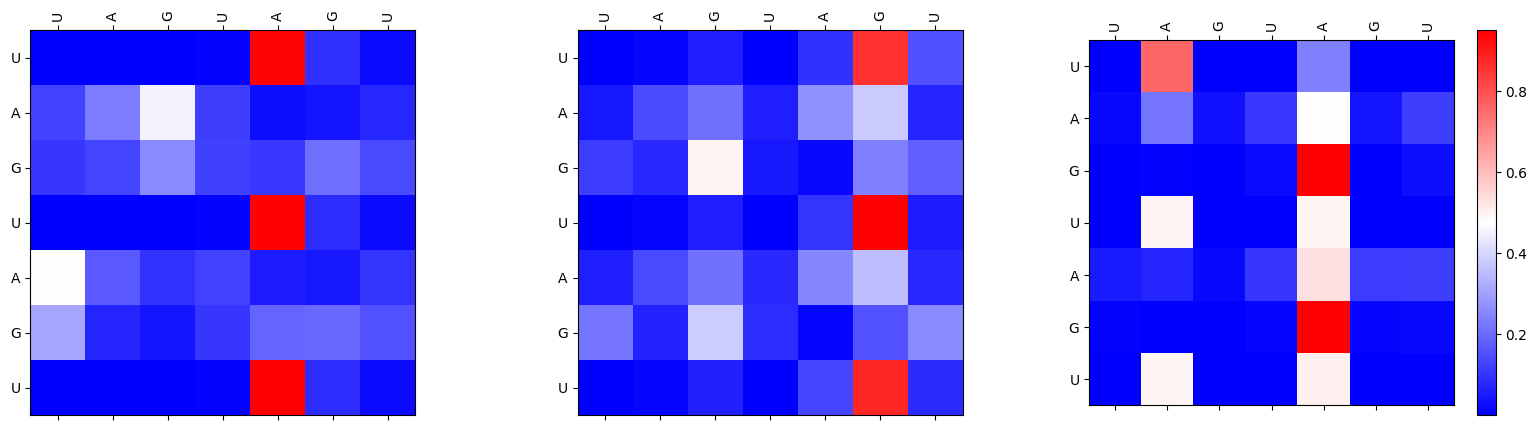

In [26]:
#Creation of the attention-based matrix heatmap to demonstrate binding relationships

seq = 'UAGUAGU'
sequence_var = df[df.sevenMer == seq].seq_spaced
prob_for_show = df[df.sevenMer == seq].RKA_logplus1
p = vectorize_layer(sequence_var)
result = model(p)
att = model.layers[1].get_attention()['attentions_1'][0]
R = sequence_var.str.split(" ")

plot_attention_head(R,att, num_heads)
print('sequence: ', sequence_var.to_numpy())
print(f'predicted: {result.numpy()}, real {prob_for_show}')

Verify Results

155/155 [==============================] - 1s 3ms/step


<Axes: xlabel='RKA'>

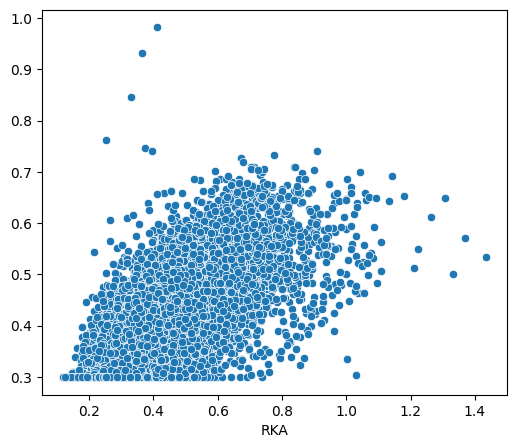

In [27]:
result = model.predict(all_vec_seq.batch(100))
result.shape



plt.rcParams["figure.figsize"] = (6,5)
sns.scatterplot(x=np.log(1+df.RKA), y=np.log(np.exp(result)))

In [28]:
# Calculate R^2
from sklearn.metrics import r2_score
r2_score(np.log(1+df.RKA), result)


0.4254597158761765

In [ ]:

'''# Calculate AUC 
y_result = model.predict(y_test.batch(100))
auc = metrics.roc_auc_score(y_test, y_result)

print(auc)'''


AttributeError: ignored